# Attention Mechanism

In :numref:chapter_seq2seq, we encode the source sequence input information in the recurrent unit state and then pass it to the decoder to generate the target sequence. A token in the target sequence may closely relate to some tokens in the source sequence instead of the whole source sequence. For example, when translating "Hello world." to "Bonjour le monde.", "Bonjour" maps to "Hello" and "monde" maps to "world". In the seq2seq model, the decoder may implicitly select the corresponding information from the state passed by the decoder. The attention mechanism, however, makes this selection explicit.

Attention is a generalized pooling method with bias alignment over inputs. The core component in the attention mechanism is the attention layer, or called attention for simplicity. An input of the attention layer is called a query. For a query, the attention layer returns the output based on its memory, which is a set of key-value pairs. To be more specific, assume a query $\mathbf{q}\in\mathbb R^{d_q}$, and the memory contains $n$ key-value pairs, $(\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_n, \mathbf{v}_n)$, with $\mathbf{k}_i\in\mathbb R^{d_k}$, $\mathbf{v}_i\in\mathbb R^{d_v}$. The attention layer then returns an output $\mathbf o\in\mathbb R^{d_v}$ with the same shape as a value.

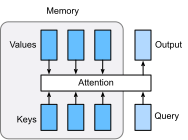

In [244]:
from IPython.display import SVG
SVG('./img/attention.svg')

To compute the output, we first assume there is a score function $\alpha$ which measures the similarity between the query and a key. Then we compute all $n$ scores $a_1, \ldots, a_n$ by

$$a_i = \alpha(\mathbf q, \mathbf k_i).$$

Next we use softmax to obtain the attention weights

$$b_1, \ldots, b_n = \textrm{softmax}(a_1, \ldots, a_n).$$

The output is then a weighted sum of the values

$$\mathbf o = \sum_{i=1}^n b_i \mathbf v_i.$$

Different choices of the score function lead to different attention layers. We will discuss two commonly used attention layers in the rest of this section. Before diving into the implementation, we first introduce a masked version of the softmax operator and explain a specialized dot operator nd.batched_dot.

In [259]:
import math
import torch 
import torch.nn as nn

The masked softmax takes a 3-dim input and allows us to filter out some elements by specifying valid lengths for the last dimension. (Refer to :numref:chapter_machine_translation for the definition of a valid length.)

In [260]:
def SequenceMask(X, X_len,value=0):
    maxlen = X.size(1)
    mask = torch.arange((maxlen),dtype=torch.float)[None, :] < X_len[:, None]    
    X[~mask]=value
    return X

In [261]:
# Save to the d2l package.
def masked_softmax(X, valid_length):
    # X: 3-D tensor, valid_length: 1-D or 2-D tensor
    softmax = nn.Softmax()
    if valid_length is None:
        return softmax(X)
    else:
        shape = X.shape
        if valid_length.dim() == 1:
            valid_length = torch.FloatTensor(valid_length.numpy().repeat(shape[1], axis=0))
        else:
            valid_length = valid_length.reshape((-1,))
        # fill masked elements with a large negative, whose exp is 0
        X = SequenceMask(X.reshape((-1, shape[-1])), valid_length)
        return softmax(X).reshape(shape)

Construct two examples, where each example is a 2-by-4 matrix, as the input. If we specify the valid length for the first example to be 2, then only the first two columns of this example are used to compute softmax.

In [262]:
masked_softmax(torch.rand((2,2,4),dtype=torch.float), torch.FloatTensor([2,3]))

tensor([[[0.4611, 0.1822, 0.1783, 0.1783],
         [0.3462, 0.2195, 0.2172, 0.2172]],

        [[0.2712, 0.3071, 0.2475, 0.1741],
         [0.2264, 0.3306, 0.3155, 0.1276]]])

The operator nd.batched_dot takes two inputs  𝑋  and  𝑌  with shapes  (𝑏,𝑛,𝑚)  and  (𝑏,𝑚,𝑘) , respectively. It computes  𝑏  dot products, with Z[i,:,:]=dot(X[i,:,:], Y[i,:,:] for  𝑖=1,…,𝑛 .



In [263]:
torch.bmm(torch.ones((2,1,3), dtype = torch.float), torch.ones((2,3,2), dtype = torch.float))

tensor([[[3., 3.]],

        [[3., 3.]]])

# Dot Product Attention

The dot product assumes the query has the same dimension as the keys, namely  𝐪,𝐤𝑖∈ℝ𝑑  for all  𝑖 . It computes the score by an inner product between the query and a key, often then divided by  𝑑‾‾√  to make the scores less sensitive to the dimension  𝑑 . In other words,

𝛼(𝐪,𝐤)=⟨𝐪,𝐤⟩/𝑑‾‾√. 
Assume  𝐐∈ℝ𝑚×𝑑  contains  𝑚  queries and  𝐊∈ℝ𝑛×𝑑  has all  𝑛  keys. We can compute all  𝑚𝑛  scores by

𝛼(𝐐,𝐊)=𝐐𝐊𝑇/𝑑‾‾√. 
Now let's implement this layer that supports a batch of queries and key-value pairs. In addition, it supports randomly dropping some attention weights as a regularization.

In [305]:
# Save to the d2l package.
class DotProductAttention(nn.Module): 
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # query: (batch_size, #queries, d)
    # key: (batch_size, #kv_pairs, d)
    # value: (batch_size, #kv_pairs, dim_v)
    # valid_length: either (batch_size, ) or (batch_size, xx)
    def forward(self, query, key, value, valid_length=None):
        d = query.shape[-1]
        # set transpose_b=True to swap the last two dimensions of key
        
        scores = torch.bmm(query, key.transpose(1,2)) / math.sqrt(d)
        attention_weights = self.dropout(masked_softmax(scores, valid_length))
        return torch.bmm(attention_weights, value)
      
 

Now we create two batches, and each batch has one query and 10 key-value pairs. We specify through valid_length that for the first batch, we will only pay attention to the first 2 key-value pairs, while for the second batch, we will check the first 6 key-value pairs. Therefore, though both batches have the same query and key-value pairs, we obtain different outputs.

In [306]:
atten = DotProductAttention(dropout=0.5)

keys = torch.ones((2,10,2),dtype=torch.float)
values = torch.arange((40), dtype=torch.float).view(1,10,4).repeat(2,1,1)
atten(torch.ones((2,1,2),dtype=torch.float), keys, values, torch.FloatTensor([2, 6]))


tensor([[[11.8325, 12.4488, 13.0650, 13.6813]],

        [[ 6.5421,  6.8987,  7.2553,  7.6118]]])

# Multilayer Perceptron Attention

In multilayer perceptron attention, we first project both query and keys into  ℝℎ .

To be more specific, assume learnable parameters  𝐖𝑘∈ℝℎ×𝑑𝑘 ,  𝐖𝑞∈ℝℎ×𝑑𝑞 , and  𝐯∈ℝ𝑝 . Then the score function is defined by

𝛼(𝐤,𝐪)=𝐯𝑇tanh(𝐖𝑘𝐤+𝐖𝑞𝐪). 
This concatenates the key and value in the feature dimension and feeds them into a single hidden layer perceptron with hidden layer size  ℎ  and output layer size  1 . The hidden layer activation function is tanh and no bias is applied.

In [307]:
# Save to the d2l package.
class MLPAttention(nn.Module):  
    def __init__(self, units, dropout, **kwargs):
        super(MLPAttention, self).__init__(**kwargs)
        # Use flatten=True to keep query's and key's 3-D shapes.
        self.W_k = nn.Linear(2, units, bias=False)
        self.W_q = nn.Linear(2, units, bias=False)
        self.v = nn.Linear(8, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, valid_length):
        query, key = self.W_k(query), self.W_q(key)
        # expand query to (batch_size, #querys, 1, units), and key to
        # (batch_size, 1, #kv_pairs, units). Then plus them with broadcast.
        features = query.unsqueeze(2) + key.unsqueeze(1)
        scores = self.v(features).squeeze(-1) 
        attention_weights = self.dropout(masked_softmax(scores, valid_length))
        return torch.bmm(attention_weights, value)

Despite MLPAttention containing an additional MLP model, given the same inputs with identical keys, we obtain the same output as for DotProductAttention.

In [308]:
atten = MLPAttention(units = 8, dropout=0.1)
atten(torch.ones((2,1,2), dtype = torch.float), keys, values, torch.FloatTensor([2, 6]))

tensor([[[12.5374, 13.3251, 14.1128, 14.9006]],

        [[21.3116, 22.4227, 23.5339, 24.6450]]], grad_fn=<BmmBackward>)

# Summary

- An attention layer explicitly selects related information.
- An attention layer's memory consists of key-value pairs, so its output is close to the values whose keys are similar to the query.